In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial
import scipy.stats
from GPy import models
import GPy

import sobol
import optunity

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN

from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_labels = 10

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


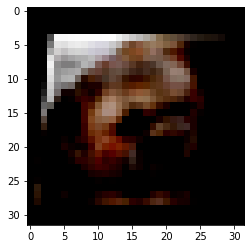

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


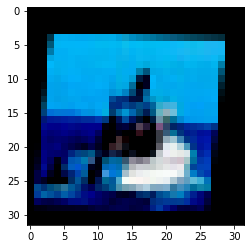

In [18]:
for i, data in enumerate(train_dataloader, 0):
    inputs, labels = data
    inputs = inputs
    labels = labels
    img = inputs[20]
    transformation = transforms.RandomAffine(10, translate=(1/20,1/20), scale=(0.8, 1), shear=10, interpolation=transforms.InterpolationMode.BILINEAR)
    inputs = transformation(inputs)
    img = inputs[1]
    img = torch.transpose(img, 2,0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    img = inputs[2]
    img = torch.transpose(img, 2,0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()
    break



In [4]:
data, labels = train_dataset[100:102]

TypeError: Cannot handle this data type: (1, 1, 32, 3), |u1

In [130]:
img = train_dataset[100][0]
transformation = transforms.RandomAffine(10, translate=(1/20,1/20), scale=(0.8, 1), shear=10, interpolation=transforms.InterpolationMode.BILINEAR)
trans_img = transformation(train_dataset)
img = torch.transpose(img, 2,0)
img = torch.transpose(img, 1,0)
plt.imshow(img)
plt.show()

trans_img = torch.transpose(trans_img, 2,0)
trans_img = torch.transpose(trans_img, 1,0)
plt.imshow(trans_img)
plt.show()
trans_img = torch.transpose(trans_img, 2,0)
trans_img = torch.transpose(trans_img, 1,0)
plt.imshow(trans_img)
plt.show()

TypeError: Cannot handle this data type: (1, 1, 32, 3), |u1

In [5]:
from Models import LeNet
criterion = CrossEntropyLoss()
input_shape = (batch_size, 3, 32, 32)

def train_mnist(lr, momentum):
    test_device = "cuda"
    model = LeNet(input_shape, 10, initial_lr=lr, momentum=momentum, weight_decay=0).to(test_device)
    train_NN(model, criterion, train_dataloader,
    test_dataloader, epochs=10, batches_to_test=1000,patience=2,device=test_device, print_test=False, verbose=False)
    return test_loss(model, test_dataloader, criterion, test_device)[1]

In [6]:
number_of_samples = 40
num_params = 2
parameterUpperLimits = np.array([0.5, 1.0])
parameterLowerLimits = np.array([0.0, 0.5])

values = np.zeros(number_of_samples)
points = np.zeros((number_of_samples, num_params))

for i in range(number_of_samples):
    lr, momentum = sobol.i4_sobol(num_params,i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    values[i] = train_mnist(lr, momentum)
    points[i] = np.array([lr, momentum])

values = values[:,None]

In [7]:
def GPPredict(lr, momentum):
    return gpmodel.predict_noiseless(np.array([[lr, momentum]]))[0]

In [8]:
def maxVarGP(lr, momentum):
    return gpmodel.predict_noiseless(np.array([[lr,momentum]]))[1]

In [9]:
iterations = 60
gp_prediction = []

for i in range(iterations):
    gpmodel = models.GPRegression(points, values,GPy.kern.Matern52(num_params, ARD = True))

    if i%2 == 0 or i >= 30:
        pars, details, _  = optunity.maximize(GPPredict, lr = [0.0, 0.5], momentum = [0.5,1])
    else:
        pars, details, _  = optunity.maximize(maxVarGP, lr = [0.0, 0.5], momentum = [0.5,1])


    q = np.array([pars['lr'], pars['momentum']])
    value = train_mnist(q[0], q[1])

    gp_prediction.append(GPPredict(q[0], q[1]))
    
    points = np.append(points, [q], axis = 0)
    values = np.append(values, [[value]], axis = 0)


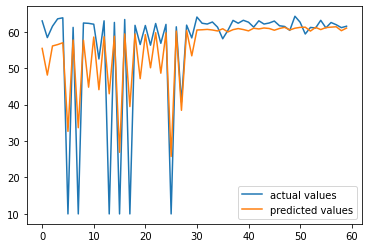

In [10]:
plt.plot(values[number_of_samples:], label = 'actual values')
plt.plot(np.array(gp_prediction)[:,0,0], label = 'predicted values')
plt.legend()
plt.show()

In [11]:
print(values)
print(points)
print(gp_prediction)

[[ 7.76]
 [55.42]
 [57.85]
 [56.55]
 [60.38]
 [10.  ]
 [58.01]
 [61.49]
 [63.13]
 [10.  ]
 [57.01]
 [59.2 ]
 [60.56]
 [41.39]
 [57.27]
 [56.96]
 [62.08]
 [10.  ]
 [55.39]
 [56.97]
 [60.5 ]
 [38.68]
 [51.25]
 [54.97]
 [62.55]
 [41.52]
 [51.26]
 [10.  ]
 [60.38]
 [10.  ]
 [60.52]
 [62.52]
 [61.08]
 [38.89]
 [58.74]
 [61.45]
 [61.73]
 [32.11]
 [57.73]
 [48.97]
 [62.99]
 [58.41]
 [61.53]
 [63.56]
 [63.84]
 [10.  ]
 [61.21]
 [10.  ]
 [62.41]
 [62.32]
 [62.08]
 [52.54]
 [63.01]
 [10.  ]
 [62.57]
 [10.  ]
 [63.37]
 [10.  ]
 [61.77]
 [56.51]
 [61.73]
 [56.32]
 [62.28]
 [56.84]
 [62.03]
 [10.  ]
 [61.37]
 [40.69]
 [61.83]
 [58.32]
 [64.05]
 [62.35]
 [62.13]
 [62.69]
 [61.27]
 [58.09]
 [60.38]
 [63.13]
 [62.35]
 [63.16]
 [62.63]
 [61.28]
 [63.02]
 [62.13]
 [62.41]
 [62.95]
 [61.66]
 [61.46]
 [60.39]
 [64.27]
 [62.63]
 [59.39]
 [61.2 ]
 [61.04]
 [63.15]
 [61.08]
 [62.55]
 [61.94]
 [61.14]
 [61.53]]
[[0.         0.5       ]
 [0.25       0.75      ]
 [0.375      0.625     ]
 [0.125      0.875     ]

In [12]:
i = np.argmax(values)
lr, momentum = points[i]
print(f"acc: {values[i][0]}")
print(f"lr: {lr}, momentum: {momentum}")

acc: 64.27
lr: 0.06580434633990487, momentum: 0.515527254925079


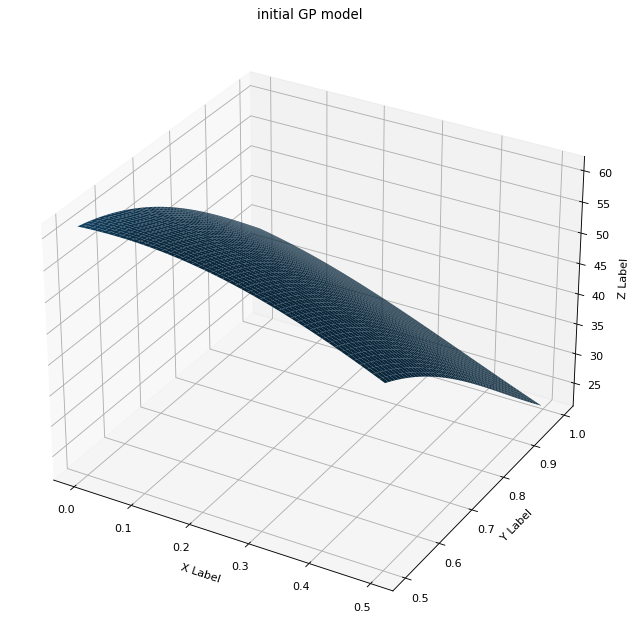

In [13]:
gpmodel = gpmodel

fig = plt.figure(figsize = (10,10), dpi = 80)
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0.0, 0.5, 0.0005)
y = np.arange(.5, 1.0, 0.005)
X, Y = np.meshgrid(x, y)
xflat = X.flatten()
yflat = Y.flatten()
p = np.array([xflat, yflat])
zs = np.array(gpmodel.predict(p.T)[0])
Z = zs.reshape(X.shape)

surf = ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_title('initial GP model')

plt.show()